## Ramblings: Tercera forma de validación, Latent Dirichlet Allocation y GridSearchCV





## Train, Test y Hold Out





>  The Three-Way Holdout Method for Hyperparameter Tuning (Raschka, 2018)



##### ¿Qué conocemos?

![](img/two-stage-cv.png)

* El proceso de búsqueda de hiperparámetros se puede considerar como una tarea de __meta-optimización__.
* Es bueno separar el proceso de optimización de la función objetivo del proceso de meta optimización. 
* El problema es que si incorporamos nuestra norma de validación (Test Set) dentro de la grilla de optimización, estaremos ajustando los hiperparámetros __en función al desempeño del testing__, lo que se puede considerar como trampa :(

##### ¿Qué deseamos saber?

![](img/three-stage-cv.png)

### Un par de comentarios


Si trabajamos con `GridSearchCV`, tan solo haciendo la división en dos muestras es suficiente, incorporando training a nuestra clase y reservando train como hold out
Si tenemos un archivo de testing externo, tal vez no sea necesario hacer división (?)

* `sklearn.model_selection.GridSearchCV().cv_results_` presenta una infinidad de cosas!
    - `split*` Indican la métrica específica en cada validación cruzada y combinación de hiperparámetros.
    - `*_time` Indican el tiempo de ejecución.
    - Por lo general trabajamos con `mean_test_score`, `mean_train_score`.
    
* `sklearn.model_selection.GridSearchCV().best_estimator_` devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros!
* `sklearn.model_selection.GridSearchCV().best_score_` devuelve el desempeño promedio del modelo en el testing interno. Si es clasificación devuelve Accuracy, si es regresión devuelve MSE.

## Latent Dirichlet Allocation

LDA busca inferir tópicos mediante el siguiente proceso: Cada documento dentro de un corpus se compone de una __mezcla de tópicos__ que se encuentran alojados __a nivel de corpus__. La estructura de tópicos es latente $\leadsto$ sólo observamos los documentos y las palabras. 

* `n_components`: Cantidad de tópicos a inferir.
* `learning_decay`: Tasa de aprendizaje en la función de pérdida. Cuando se utiliza con `online`, la optimización se hace con SGD (Stochastic Gradient Descent)
* `learning_method`:
* Perplejidad: Busca aproximar el número óptimo de tópicos a inferir. Técnicamente evalua qué tan bien predice una muestra específica. En función a un número $K$ de tópicos, define la distribución teórica de palabras reopresentada por los tópicos y la compara con la ocurrencia empírica de palabras en tópicos.


# Overlap

https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html

## Helpers en Latent Dirichlet



In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import minimal_helpers as helpers
import seaborn as sns

In [2]:
list_files = glob.glob("./data/*.csv")
append_csv = []

In [3]:
for i in list_files:
    append_csv.append(pd.read_csv(i, index_col=None, header=0).drop(columns='Unnamed: 0'))  
    
df = pd.concat(append_csv)
df.columns = ['artist', 'genre', 'song', 'lyrics'] 

In [4]:
X = df.copy()
y = X.pop('genre')
n = .33
seed = 11238

In [5]:
X_hold_in, X_hold_out, y_hold_in, y_hold_out = train_test_split(X, y, test_size=n,
                                                               random_state=seed)

X_train, X_test, y_train, y_test = train_test_split(X_hold_in, y_hold_in, test_size=n,random_state=seed)

hold_in_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
hold_in_transformed_features = hold_in_counter.fit_transform(X_hold_in['lyrics'])

hold_out_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
hold_out_transformed_features = hold_out_counter.fit_transform(X_hold_out['lyrics'])

train_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
train_transformed_feats = train_counter.fit_transform(X_train['lyrics'])
test_counter = CountVectorizer(stop_words='english', max_df=.1, max_features=5000)
test_transformed_feats = test_counter.fit_transform(X_test['lyrics'])

In [6]:
search_params = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}
cv_lda_model = GridSearchCV(
    LatentDirichletAllocation(learning_method='online'),
    param_grid = search_params,
    n_jobs=-1).fit(hold_in_transformed_features)

/Users/veterok/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [7]:
store_hold_in_perplexity = []
store_combination = []
for i in [5, 10, 15]:
    for j in [0.5, 0.7]:
        tmp = LatentDirichletAllocation(n_components = i,
                                       learning_decay = j,
                                       learning_method = 'batch')
        tmp.fit(hold_in_transformed_features)
        store_hold_in_perplexity.append(tmp.perplexity(hold_in_transformed_features))
        store_combination.append(f"K={i}, eta={j}")

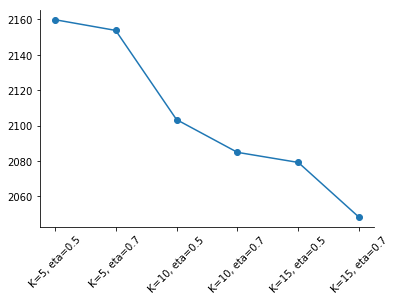

In [8]:
plt.plot(store_hold_in_perplexity, '-o')
plt.xticks(range(len(store_combination)), store_combination, rotation=45);
sns.despine()

In [9]:
cv_lda_model.best_params_

{'learning_decay': 0.5, 'n_components': 5}

In [10]:
best_lda = cv_lda_model.best_estimator_

In [11]:
helpers.identify_words_associated(best_lda,
                                  hold_in_counter,
                                  20)

Tópico: 0		
ooh la tonight ah dance rock ha body na yes alright forever christmas lonely babe mama roll goodbye sweet girls
Tópico: 1		
death blood pain kill hell war cold alive lord born burn fear earth fight rain watch coming dark land king
Tópico: 2		
believe wrong didn maybe knew remember comes help somebody told wait best days looking friends times stand goes understand care
Tópico: 3		
niggas uh niggaz gon ho ma rap beat fuckin gettin wit damn bitches game check bout word kid chorus rock
Tópico: 4		
song future moment jam raise page lyrics power sound able game follow mos rockin def self force mi bit display


In [12]:
infer_df = helpers.identify_most_likely_topic(best_lda,hold_in_counter,
                                              hold_in_transformed_features,
                                              X_hold_in)

Tópico 3    0.200842
Tópico 2    0.160592
Tópico 1    0.040343
Tópico 5    0.046232
Tópico 4    0.552012
dtype: float64

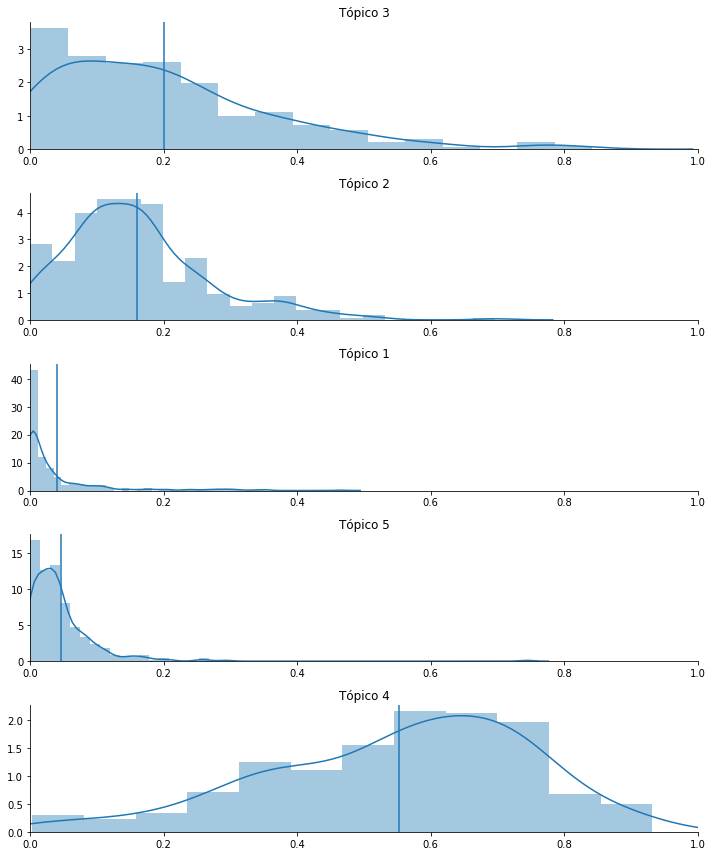

In [13]:
plt.figure(figsize=(10, 12))
helpers.report_artist_topic(infer_df, 'Eminem')